### 0. Food for thought

If you think about, Time Series are all around you. For example, stock market, food prices, how much water you use at home daily or how frequent you opening your Facebook app. Time series, basically put all the information in relation of time.

What you have seen in a lecture, that is the gist of it. We could go deeper in mathematic and probability, but the main key to identify how a certian phenonmena behave in time:
* Is the electricity price increasing (upward trend)
* Are we using more water at the weekend (weekly seasonality)
* Sudden increase in online purchase during 2020 (irregularity)
* House purchase over the years. (Cyclicity)

When you recieve a time series, you want to answer some question, by just looking at the data:
* Can I see some trending or seasonal behavior with my data
* Can make an educated guess about the next probable value
* Does it look like a random noise ? it is? then lets do some crunching, is it really a noise.

### 1. Importing libraries

As you may already know, we need some libaries to use some predifined function, so we do not need to reinvent the wheel. So lets use other people work. (That is called open-source)

We are going to use in the first part of the exercise the __datetime__ base library and __pandas__ data wrangling library. It is a good practise to use __as__ for shortening the names.

In [ ]:
import datetime as dt
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

#IGnore warnings
import warnings
warnings.filterwarnings('ignore')


### 2. Loading the Dataset
* Load data with the __pd.read_csv__ function by specifying the location of the dataset, which is in your __data__ folder.
* After loading the data, it is good to see how the data was loaded. Sometime, we can spot some errors in the original dataset.

In [1]:
air_pass = pd.read_csv("data/AirPassengers.csv")
air_pass.head(1)

NameError: ignored

### 3. Analyzing the data

After you are confirmed that the data was loaded correctly, you always want to start with getting to know the dataset. Without knowing what our dataset contains, we don't know what it is that we are working with. This step sets up the possibilty for you to identify missing or incorrect data. It is an important prerequisite for data cleaning!

In [ ]:
air_pass.info()

NameError: ignored

### 4. Cleaning the Data
After identifying the general characteristics of our dataset, we can clean it up. Below, you can see a couple of queries that you can perform to make your data cleaner. Clean data is the fundation of a good data analysis! Cleaning the dataset can include, but is not limited to:

* Dealing with missing values
    * Instead of removing the missing values, let's interpolate (create a new values, based their neighbouring values.)  
* Formating date columns
    * Let's create a separate date column, plus a separate year and month
* Adding calculated columns
    * And let's create and extra column based on how many data we have in a year.

After we are satisfied with the cleanliness of our dataset, we should always save it under a new name. This allows you to look back at the original dataset easily and have a clear separation between the cleaned and raw dataset. You do not have to run the cleaning code again, and can simply work with the already cleaned dataset next time you open up the code.

In [ ]:
#we don't like # and capital letter in the column name, so we will rename it
air_pass.rename(columns={"#Passengers": "passengers"}, inplace=True)

#count missing values by columns
print("Check for missing values:")
print(air_pass.isnull().sum())
#We can see we have 3 in the passengers column
# Let's interpolate the missing values, based on their previous and next values
air_pass["passengers"].interpolate(inplace=True)

#Did we succeed?
print("Check for missing values:")
print(air_pass.isnull().sum())

#Create the date, year, month  and drop the Month column
air_pass["date"] = pd.to_datetime(air_pass["Month"], format="%Y-%m")
air_pass["year"] = air_pass["date"].dt.year
air_pass["month"] = air_pass["date"].dt.month

air_pass.drop("Month", axis=1, inplace=True)

#Set the column order
air_pass = air_pass[["date","year", "month","passengers"]]

#Check the data types
air_pass.dtypes

Check for missing values:
Month         0
passengers    0
dtype: int64
Check for missing values:
Month         0
passengers    0
dtype: int64


date          datetime64[ns]
year                   int64
month                  int64
passengers             int64
dtype: object

In [ ]:
#Lets set the year and month as the index
air_pass.set_index(["year","month"], inplace=True)
air_pass

date  passengers
year month                       
1949 1     1949-01-01         112
     2     1949-02-01         118
     3     1949-03-01         132
     4     1949-04-01         129
     5     1949-05-01         121
...               ...         ...
1960 8     1960-08-01         606
     9     1960-09-01         508
     10    1960-10-01         461
     11    1960-11-01         390
     12    1960-12-01         432

[144 rows x 2 columns]

### 5 Exploratory Data Analysis (EDA) Stationarity check

Lets use some addintional libraries which out of the box helps to decompose our dataset, to see some trend, seasonality and irregularites.


In [ ]:
#Decompose the time series into trend, seasonality and residuals
from statsmodels.tsa.seasonal import seasonal_decompose

#Lets drop the year and month index
air_pass.reset_index(inplace=True)
air_pass.drop(["year", "month"], axis=1, inplace=True)
air_pass.set_index("date", inplace=True)

When we are dealing with Time Series, we are doing so to be able to use them to predict the future. We want to see whether the past data can indicate a future behavior and possibly we can take an action, or utilize the predictions.

There are miriad of models and algorithms have been developed over the years in order to predict future. But most of them rely on one specific feature of the time series, that is it stationary or not.

So let's see

In [ ]:
#In the previous task we have seen that the time series is non-stationary, by looking at the mean and variance
#and also we have seen that there is some seasonality in the data by looking at the plot
#Lets check if the time series is stationary by using the Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

#Lets create a function to check if the time series is stationary
def check_stationarity(timeseries, return_rol=False):

    #Determing rolling statistics
    #Rolling statistics is used to check if the mean and variance is constant over time
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15, 5))
    plt.plot(timeseries, color="blue", label="Original")
    plt.plot(rolmean, color="red", label="Rolling Mean")
    plt.plot(rolstd, color="black", label="Rolling Std")
    plt.legend(loc="best")
    plt.title("Rolling Mean & Standard Deviation")
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput[f"Critical Value ({key})"] = value
    print(dfoutput)

    if return_rol:
         return rolmean, rolstd

Augmented Dickey Fuller test or (ADF Test) is the most commonly used test to detect stationarity. Here, we assume (inn statistics we say the null-hypothesis) the time series is non-stationary. Then, we collect evidence to support or reject our assumptions(null hypothesis). So, if we find that the __p-value__ in ADF test is less than the significance level (__0.05__), we can reject our assumptions and we can declare the timeseries is stationary.

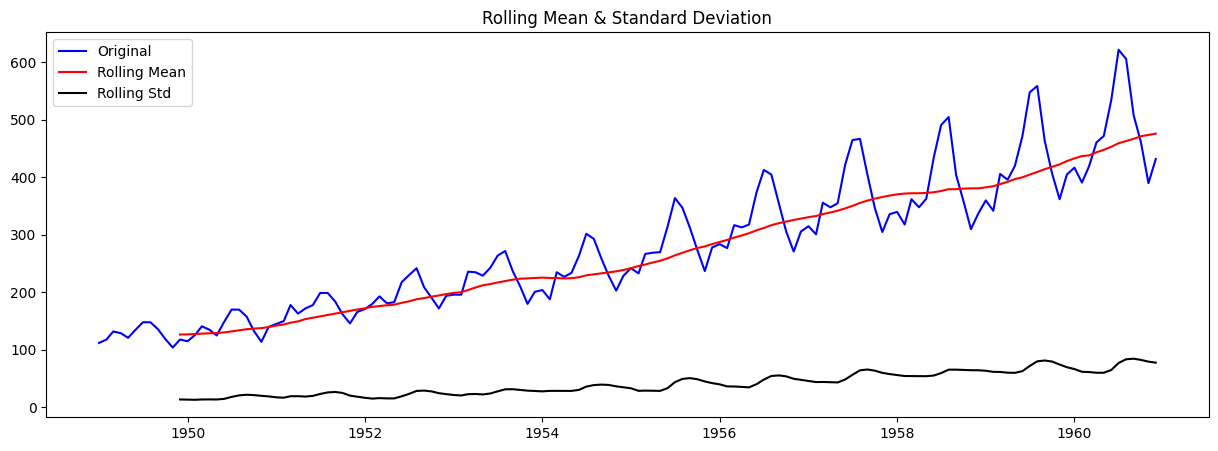

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [ ]:
#Lets check if the time series is stationary by using the Augmented Dickey-Fuller test
check_stationarity(air_pass["passengers"])
#We can see that the p-value is greater than 0.05, so we can't reject the null hypothesis

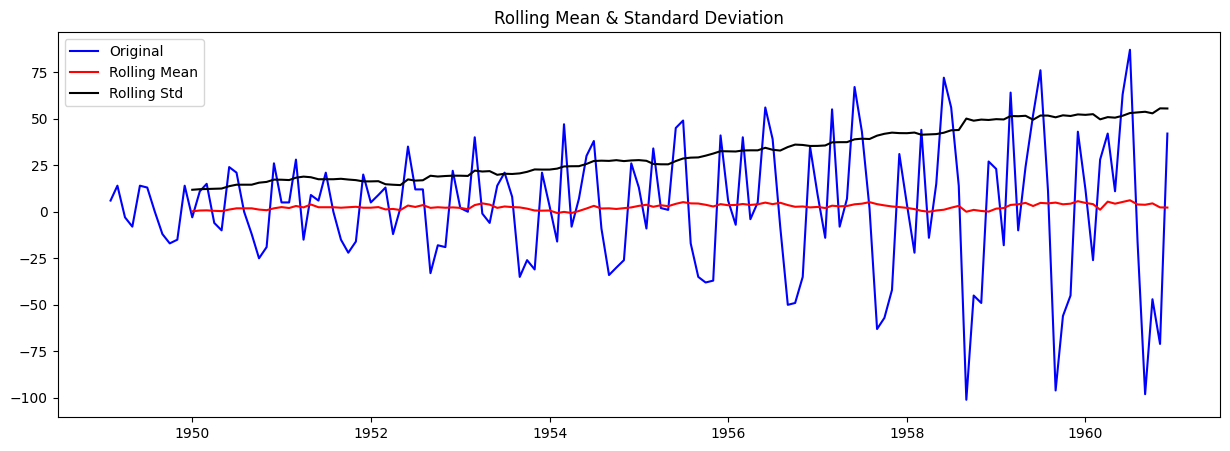

Results of Dickey-Fuller Test:
Test Statistic                  -2.829267
p-value                          0.054213
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [ ]:
#Lets do some differencing , shall we?
air_pass["passengers_diff"] = air_pass["passengers"].diff()

check_stationarity(air_pass["passengers_diff"][1:])
#We will use this time series despite it just fails on the stationarity test.
#Effect of double-differencing would be too heavy on the data and might result in poor performance


### The Arima Model

__What is ARIMA model?__

ARIMA(Auto Regressive Integrated Moving Average) is a combination of 2 models AR(Auto Regressive) & MA(Moving Average). It has 3 hyperparameters (three input, which we need to specify) - __P(auto regressive lags)__, __d(order of differentiation)__ and __Q(moving avg.__ which respectively comes from the AR, I & MA components. 
 - The AR part is correlation between prev & current time periods. 
 - To smooth out the noise, the MA part is used.
 - The I part binds together the AR & MA parts.

__How to find value of P & Q for ARIMA ?__

We need to take help of __ACF(Auto Correlation Function)__ & __PACF(Partial Auto Correlation Function)__ plots.
ACF & PACF graphs are used to find value of P & Q for ARIMA. We need to check, for which value in x-axis, graph line drops to 0 in y-axis for 1st time. From PACF(at y=0), get P From ACF(at y=0), get Q


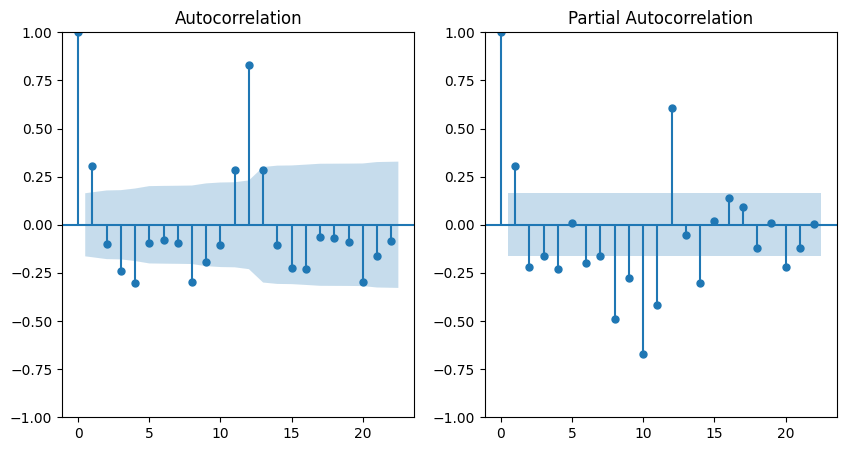

In [ ]:
#Lets plot the ACF and PACF of the time series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Calculate ACF and PACF:
fig, ax = plt.subplots(1,2,figsize=(10,5))

plot_acf(air_pass["passengers_diff"].dropna(), ax=ax[0]); # For ACF the graph drops somewhere between 1 and 2. So, q = 1 or 2
plot_pacf(air_pass["passengers_diff"].dropna(), ax=ax[1]); # For PACF the graph drops somewhere between 1 and 2. So, p = 1 or 2


In [ ]:
#lets make train and test set
train = air_pass[:int(0.8*(len(air_pass)))]
test = air_pass[int(0.8*(len(air_pass))):]

print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')

Train shape: (115, 11)
Test shape: (29, 11)


In [ ]:
#lets create the model and fit it  
from statsmodels.tsa.arima.model import ARIMA
#import mape function
from sklearn.metrics import r2_score

#Create the model
model = ARIMA(train["passengers"], order=(2, 1, 2))
#Fit the model
result_arima = model.fit()

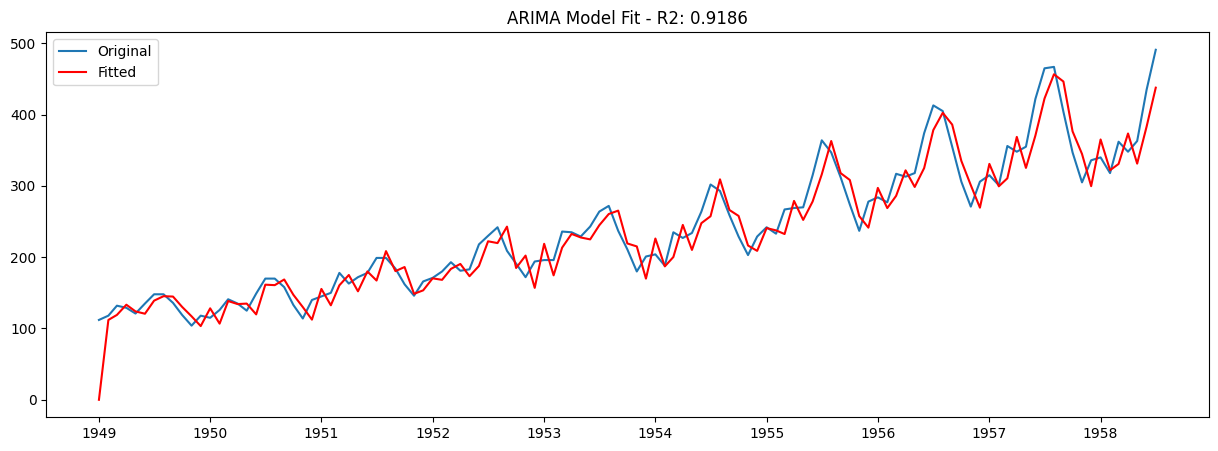

In [ ]:
#plot the fitted values
plt.figure(figsize=(15, 5))
plt.plot(train["passengers"], label="Original")
plt.plot(result_arima.fittedvalues, color="red", label="Fitted")
plt.legend(loc="best")
plt.title("ARIMA Model Fit - R2: %.4f" % r2_score(train["passengers"], result_arima.fittedvalues))
plt.show(block=False)

#Looks like the model is doing a good job in fitting the data, but seems like there is a lag in the fitted values

In [ ]:
#Lets forecast the test set
prediction_arima = result_arima.get_forecast(steps=29)
prediction_arima_mean = prediction_arima.predicted_mean
prediction_arima_ci = prediction_arima.conf_int()

#Lets create a dataframe with the forecasted values
forecast_air_pass=pd.DataFrame({"arima_forecasted_values":prediction_arima_mean})

#add the confidence interval
forecast_air_pass["arima_lower_bound"]=prediction_arima_ci["lower passengers"]
forecast_air_pass["arima_upper_bound"]=prediction_arima_ci["upper passengers"]

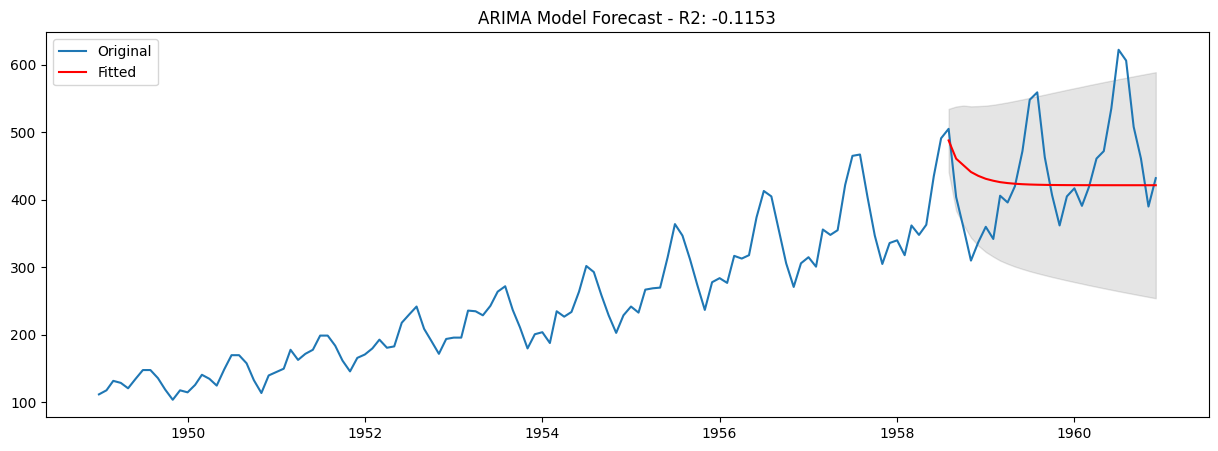

In [ ]:
# #Lets plot the forecasted values and the confidence interval
plt.figure(figsize=(15, 5))
plt.plot(air_pass["passengers"], label="Original")
plt.plot(forecast_air_pass["arima_forecasted_values"], color="red", label="Fitted")
plt.fill_between(
    forecast_air_pass.index,
    forecast_air_pass["arima_lower_bound"],
    forecast_air_pass["arima_upper_bound"],
    color="k",
    alpha=0.1,
)
plt.title("ARIMA Model Forecast - R2: %.4f" % r2_score(test["passengers"], forecast_air_pass["arima_forecasted_values"]))
plt.legend(loc="best")
plt.show(block=False)

#not really good is it? lets try another model

### SARIMAX MODEL

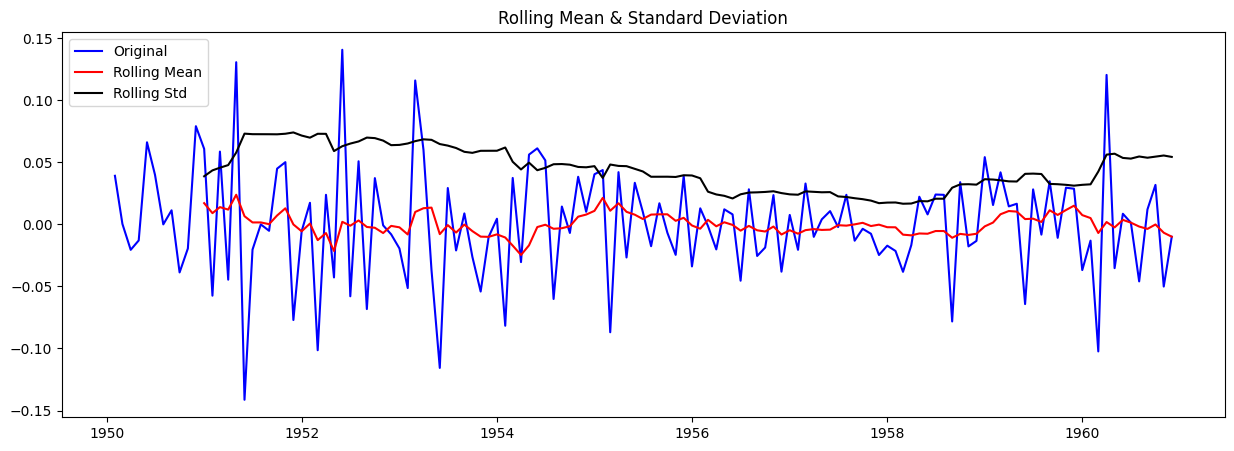

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


In [ ]:
air_pass["passenger_log_diff12"] = air_pass["passengers_log_diff"].diff(periods=12)
check_stationarity(air_pass["passenger_log_diff12"].dropna())

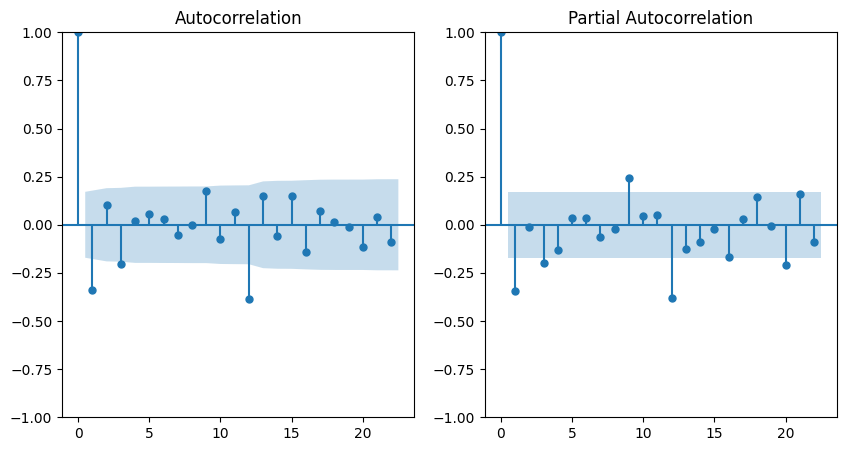

In [ ]:
#Lets plot the ACF and PACF of the time series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Calculate ACF and PACF:
fig, ax = plt.subplots(1,2,figsize=(10,5))
plot_acf(air_pass["passenger_log_diff12"].dropna(), ax=ax[0]); # For ACF the graph drops somewhere between 0 and 1. So, q = 0 or 1
plot_pacf(air_pass["passenger_log_diff12"].dropna(), ax=ax[1]); # For PACF the graph drops somewhere between 0 and 1. So, p = 0 or 1

In [ ]:
#Import Sarimax model
from statsmodels.tsa.statespace.sarimax import SARIMAX
#Create a SARIMAX model
model_sarimax = SARIMAX(train["passengers"].dropna(), order=(2, 1, 2), seasonal_order=(0, 1, 1, 12)) #12 is the number of months in a year

#Fit the model
result_sarimax = model_sarimax.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.25671D+00    |proj g|=  4.34123D-02

At iterate    5    f=  3.25042D+00    |proj g|=  5.70548D-02


 This problem is unconstrained.



At iterate   10    f=  3.24273D+00    |proj g|=  1.48299D-02

At iterate   15    f=  3.23498D+00    |proj g|=  6.62059D-03

At iterate   20    f=  3.23476D+00    |proj g|=  5.43467D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     27      1     0     0   4.493D-06   3.235D+00
  F =   3.2347276386667239     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


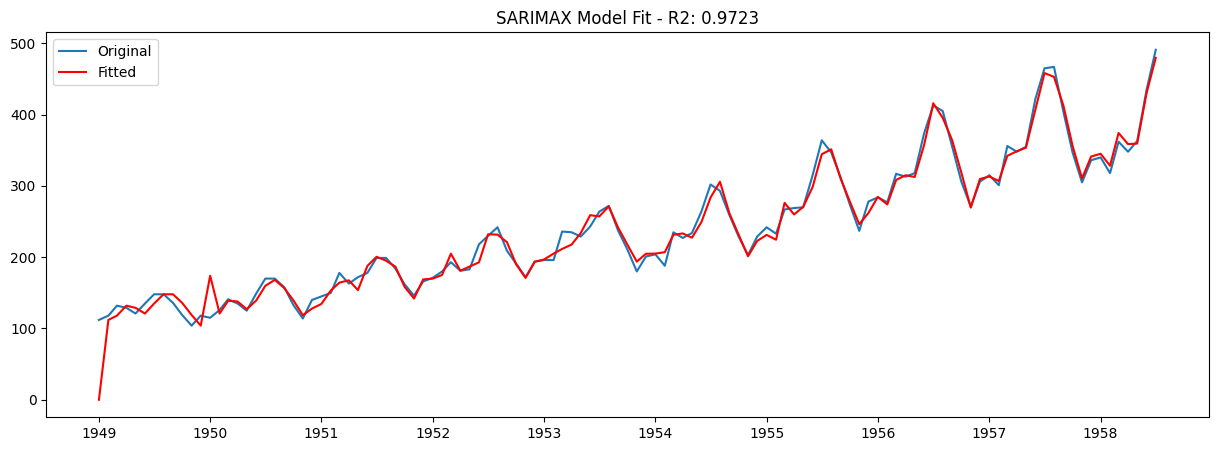

In [ ]:
#plot the fitted values
plt.figure(figsize=(15, 5))
plt.plot(train["passengers"], label="Original")
plt.plot(result_sarimax.fittedvalues, color="red", label="Fitted")
plt.legend(loc="best")
plt.title("SARIMAX Model Fit - R2: %.4f" % r2_score(train["passengers"], result_sarimax.fittedvalues))
plt.show(block=False)


In [ ]:
#Lets forecast the test set
prediction_sarimax = result_sarimax.get_forecast(steps=29)
prediction_mean = prediction_sarimax.predicted_mean 
prediction_sarimax_ci = prediction_sarimax.conf_int()

#Lets create a dataframe with the forecasted values
forecast_air_pass=pd.DataFrame({"sarimax_forecasted_values":prediction_mean})

#add the confidence interval
forecast_air_pass["sarimax_lower_bound"]=prediction_sarimax_ci["lower passengers"]
forecast_air_pass["sarimax_upper_bound"]=prediction_sarimax_ci["upper passengers"]

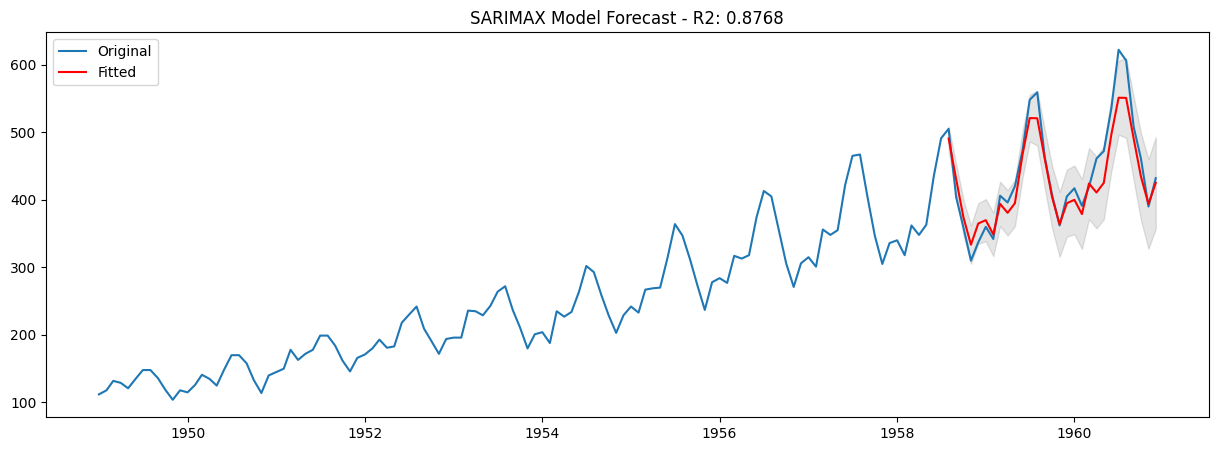

In [ ]:
# #Lets plot the forecasted values and the confidence interval
plt.figure(figsize=(15, 5))
plt.plot(air_pass["passengers"], label="Original")
plt.plot(forecast_air_pass["sarimax_forecasted_values"], color="red", label="Fitted")
plt.fill_between(
    forecast_air_pass.index,
    forecast_air_pass["sarimax_lower_bound"],
    forecast_air_pass["sarimax_upper_bound"],
    color="k",
    alpha=0.1,
)
plt.title("SARIMAX Model Forecast - R2: %.4f" % r2_score(test["passengers"], forecast_air_pass["sarimax_forecasted_values"]))
plt.legend(loc="best")
plt.show(block=False)

### AUTO ARIMA 

In [ ]:
from pmdarima.arima import auto_arima

model_auto_arima=auto_arima(train["passengers"],start_p=0,d=1,start_q=0,
          max_p=5,max_d=5,max_q=5, start_P=0,
          D=1, start_Q=0, max_P=5,max_D=5,
          max_Q=5, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=757.826, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=755.750, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=756.380, Time=0.13 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=755.499, Time=0.03 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=755.982, Time=0.12 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=757.649, Time=0.19 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=756.771, Time=0.04 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=756.022, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=756.011, Time=0.01 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=757.976, Time=0.03 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=757.438, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 0.680 seconds


In [ ]:
#Lets forecast the test set
prediction_auto_arima, prediction_auto_arima_ci = model_auto_arima.predict(n_periods=29, return_conf_int=True)

#Lets create a dataframe with the forecasted values
forecast_air_pass=pd.DataFrame({"auto_arima_forecasted_values":prediction_auto_arima})

#add the confidence interval
forecast_air_pass["auto_arima_lower_bound"]=prediction_auto_arima_ci[:,0]
forecast_air_pass["auto_arima_upper_bound"]=prediction_auto_arima_ci[:,1]

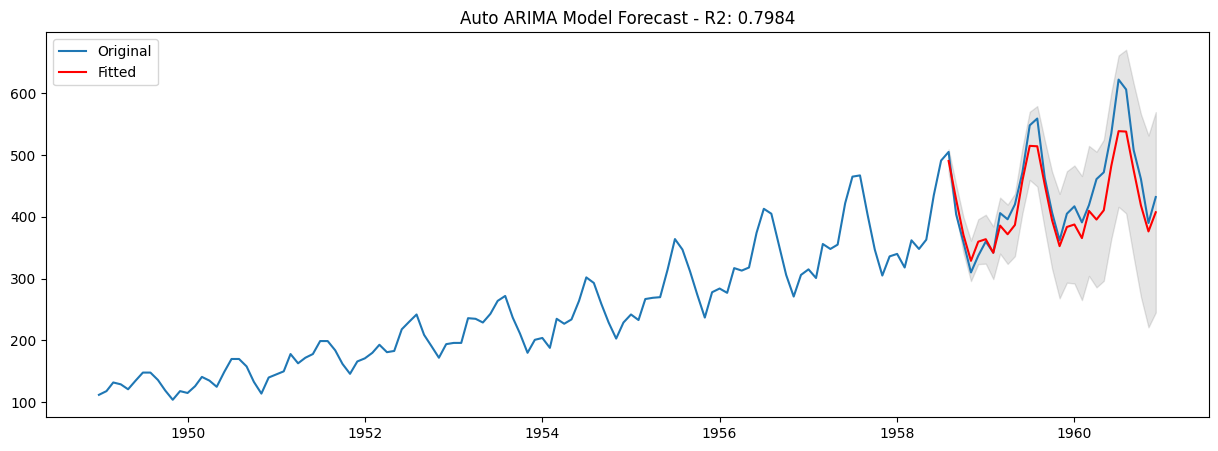

In [ ]:
#Lets plot the forecasted values and the confidence interval
plt.figure(figsize=(15, 5))
plt.plot(air_pass["passengers"], label="Original")
plt.plot(forecast_air_pass["auto_arima_forecasted_values"], color="red", label="Fitted")
plt.fill_between(
    forecast_air_pass.index,
    forecast_air_pass["auto_arima_lower_bound"],
    forecast_air_pass["auto_arima_upper_bound"],
    color="k",
    alpha=0.1,
)
plt.title("Auto ARIMA Model Forecast - R2: %.4f" % r2_score(test["passengers"], forecast_air_pass["auto_arima_forecasted_values"]))
plt.legend(loc="best")
plt.show(block=False)

#Woow that was super easy and the forecasted values look good.
